In [1]:
import numpy as np
import matplotlib.pyplot as plt

from rfest import get_spatial_and_time_filters
from rfest.MF import SemiNMFSpline

import pickle


## Load Data
    
** This notebook use data from [(Liu et. al. 2018)](https://www.nature.com/articles/s41467-017-00156-9). You can download it [here](https://gin.g-node.org/doi/Liu_etal_2017_RGC_spiketrains_for_STNMF).

In [2]:
with open('../../data_gollisch_processed/cell0.pickle', 'rb') as f:
    data = pickle.load(f)
    
X = data['X']
y = data['y']
del data

## Factorize the Spike-triggered Ensemble using spline-based semi-NMF

In [3]:
V = X[y != 0]
dims=[20, 25, 25]
num_subunits = 8
snmf = SemiNMFSpline(V.T, dims, df=9, k=num_subunits)
snmf.fit(num_iters=5000)

100%|██████████| 5000/5000 [1:12:29<00:00,  1.17it/s]


## Plots RGC Receptive field

In [4]:
W = snmf.S @ snmf.B # subunits

/usr/local/lib/python3.6/dist-packages/jax/lib/xla_bridge.py:115: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


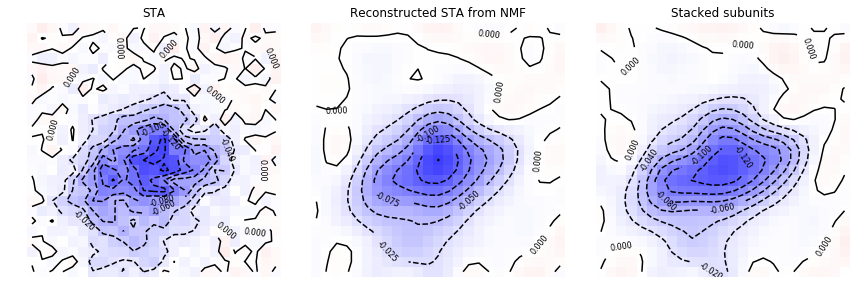

In [5]:
fig, ax = plt.subplots(1,3, figsize=(12,4))
ax = ax.flatten()
sRF_mle, tRF_mle = get_spatial_and_time_filters(V.mean(0), dims)
sRF_spl, tRF_spl = get_spatial_and_time_filters((snmf.S @ snmf.B @ snmf.H).mean(1), dims)
sRF_opt, tRF_opt = get_spatial_and_time_filters(W.mean(1), dims)

ax[0].imshow(sRF_mle.reshape(25, 25), origin='lower', cmap=plt.cm.bwr, vmin=-0.2, vmax=0.2)
cntr = ax[0].contour(sRF_mle, colors='black')
ax[0].clabel(cntr, inline=True, fontsize=8)
ax[0].set_title('STA')
ax[1].imshow(sRF_spl.reshape(25, 25), origin='lower', cmap=plt.cm.bwr, vmin=-0.2, vmax=0.2)
cntr = ax[1].contour(sRF_spl, colors='black')
ax[1].clabel(cntr, inline=True, fontsize=8)
ax[1].set_title('Reconstructed STA from NMF')
ax[2].imshow(sRF_opt.reshape(25, 25), origin='lower', cmap=plt.cm.bwr, vmin=-0.2, vmax=0.2)
cntr = ax[2].contour(sRF_opt, colors='black')
ax[2].clabel(cntr, inline=True, fontsize=8)
ax[2].set_title('Stacked subunits')

for i in range(3):
    ax[i].axis('off')
plt.tight_layout()

## Plot all subunit receptive fields

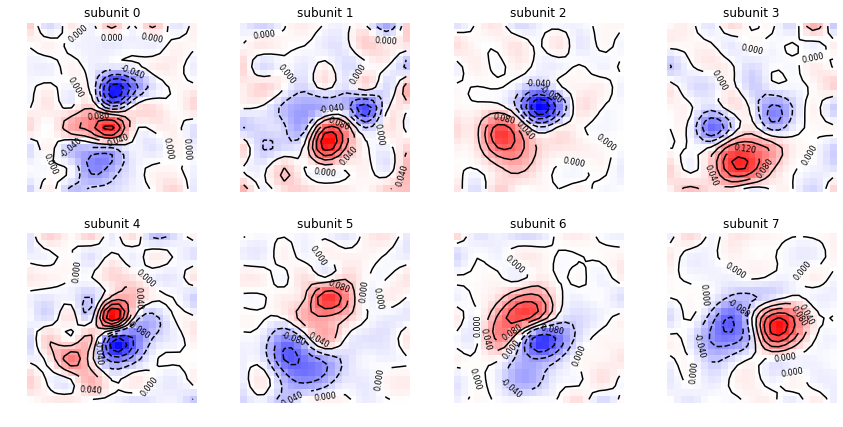

In [7]:
cntr_levels = np.array([-0.2 , -0.16, -0.12, -0.08, -0.04, 0,  
                        0.04,  0.08,  0.12, 0.16, 0.2])

fig, ax = plt.subplots(2,4, figsize=(12, 6))
ax = ax.flatten()
cntrs_m = []
cntrs_p = []
for i in range(num_subunits):
    ksub = W[:, i].reshape(dims[0], np.product(dims[1:]))
    ksub_norm = ksub / np.linalg.norm(ksub)
    sRF, tRF = get_spatial_and_time_filters(ksub_norm, dims)
    cntrs = ax[i].contour(sRF, colors='black', levels=cntr_levels)
    
    cntrs_m.append(cntrs.collections[3].get_paths()[0].vertices)
    cntrs_p.append(cntrs.collections[7].get_paths()[0].vertices)
    
    ax[i].clabel(cntrs, inline=True, fontsize=8)
    ax[i].imshow(sRF.reshape(25, 25), origin='lower', cmap=plt.cm.bwr, vmin=-0.2, vmax=0.2)
    ax[i].set_title('subunit {}'.format(i))
    ax[i].axis('off')
    
plt.tight_layout()    

## Plot subunit contours on RGC RF

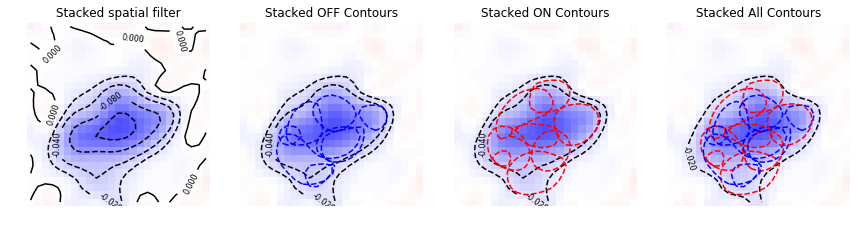

In [10]:
cntr_levels = np.array([-0.2 , -0.16, -0.12, -0.08, -0.04, -0.02, 0.  ,  
                        0.04,  0.08,  0.12, 0.16, 0.2])

fig, ax = plt.subplots(1,4, figsize=(12,4))
kstack = W.mean(1).reshape(dims[0], np.product(dims[1:]))
kstack_norm = kstack / np.linalg.norm(kstack)
sRF, tRF = get_spatial_and_time_filters(kstack_norm, dims)
ax[0].imshow(sRF.reshape(25, 25), origin='lower', cmap=plt.cm.bwr, vmin=-0.2, vmax=0.2)
cntr = ax[0].contour(sRF, colors='black', levels=cntr_levels)
ax[0].clabel(cntr, inline=True, fontsize=8)
ax[0].set_title('Stacked spatial filter')

ax[1].imshow(sRF.reshape(25, 25), origin='lower', cmap=plt.cm.bwr, vmin=-0.2, vmax=0.2)
cntr = ax[1].contour(sRF, colors='black', levels=[-0.04 , -0.02, ])
for i in range(num_subunits):
    ax[1].plot(cntrs_m[i][:, 0], cntrs_m[i][:, 1], color='blue', ls='--')
ax[1].clabel(cntr, inline=True, fontsize=8)
ax[1].set_title('Stacked OFF Contours')


ax[2].imshow(sRF.reshape(25, 25), origin='lower', cmap=plt.cm.bwr, vmin=-0.2, vmax=0.2)
cntr = ax[2].contour(sRF, colors='black', levels=[ -0.04 , -0.02,])
for i in range(num_subunits):
    ax[2].plot(cntrs_p[i][:, 0], cntrs_p[i][:, 1], color='red', ls='--')
ax[2].clabel(cntr, inline=True, fontsize=8)
ax[2].set_title('Stacked ON Contours')
plt.tight_layout()

ax[3].imshow(sRF.reshape(25, 25), origin='lower', cmap=plt.cm.bwr, vmin=-0.2, vmax=0.2)
cntr = ax[3].contour(sRF, colors='black', levels=[-0.02])
for i in range(num_subunits):
    ax[3].plot(cntrs_m[i][:, 0], cntrs_m[i][:, 1], color='blue', ls='--')
    ax[3].plot(cntrs_p[i][:, 0], cntrs_p[i][:, 1], color='red', ls='--')
ax[3].clabel(cntr, inline=True, fontsize=8)
ax[3].set_title('Stacked All Contours')

for i in range(4):
    ax[i].axis('off')

plt.tight_layout()

Unlike the subunits retrieved using semi-NMF, which imposing nonnegative constraints on them, in the original paper (Liu et al, 2017), Spline-based semi-NMF (in this case we also relax the nonnegative constraints) found two antagonistic fields for each subunit. The contours of those subunits from both components can be fitted into GC receptive fields, but those subunits are not unique, in the sense that a rerun of the algorithm will yields different subunits.